# Notebook Nombres Premiers

> **Groupe D**
>
> Alexandre De Cuyper
>
> Hendrix Montalvan

1. [Introduction](#Introduction)
2. [Données](#Données)
3. [Modèle](#Modèle)
4. [Visualisation](#Visualisation)
5. [Résultats](#Résultats)

# Introduction

---

On cherche a faire un réseau qui prédit si un nombre est un nombre premier. 

On va utiliser l'apprentissage supervisé avec une classification binaire (nombres premiers et les multiples). On va diviser les données en 2 groupes: entrainement et test. 

Dans ce Notebook nous allons voir si un réseau de neurones est capable de prédire si un nombre est premier ou non en lui montrant un jeu de données de plusieurs millions de nombres premiers et de multiples.

Nous allons pour cela tester 2 types de datasets différents, un en base décimal et un en base binaire pour voir si cela a un impact sur les prédicitons faite par le modèle. 

## Importations néscessaires

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D

#import os ; os.environ['KERAS_BACKEND'] = 'theano'
import keras
import keras.models as km
import keras.layers as kl
from tensorflow.keras import regularizers
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

# Données

In [1]:
#@title Options pour les datasets

use_primes = True #@param {type:"boolean"}
suffix = "" if use_primes else "_mini"
use_primes_with_multiples = True #@param {type:"boolean"}
suffix = "" if use_primes_with_multiples else "_mini"

In [3]:
#@title Télécharger les données

#@markdown Ceci va télécharger l'archive depuis Github et la décompresser dans le répertoire `data`

import sys
import os
import tarfile
from urllib.request import urlretrieve

URL = "https://github.com/Undreak/MML_Nombres_Premiers/raw/master"
FILES = [
    "prime_with_multiples.tar.gz",
    "primes.tar.gz"
]


def download_data(output_dir, use_primes=False, use_primes_with_multiples=False):
  if use_primes_with_multiples:
    files = [FILES[0], '']
    urls = [f"{URL}/{files}", '']
  if use_primes:
    files = [FILES[1], '']
    urls = [f"{URL}/{files}", '']
  if use_primes and use_primes_with_multiples:
    files = FILES
    urls = [
          f"{URL}/{filename}"
          for filename in files
    ]
  
  if not os.path.exists(output_dir):
    print(f"Création du répertoire {output_dir}")
    os.mkdir(output_dir)

  for url, filename in zip(urls, files):
    if url == '':
      continue
    output_file = os.path.join(output_dir, filename)
    if os.path.exists(output_file):
      print(f"{filename} déjà téléchargé.")
      continue

    print(f"Téléchargement à partir de {url}...")
    urlretrieve(url, output_file)
    print(f"==> Fichier enregistré sous {output_file}")

    if filename.endswith("tar.gz"):
      print("Extraction de l'archive...")
      with tarfile.open(output_file, "r:gz") as f:
        f.extractall(output_dir)
      print("Terminé.\n")

download_data("data", use_primes, use_primes_with_multiples)

Création du répertoire data
Téléchargement à partir de https://github.com/Undreak/MML_Nombres_Premiers/raw/master/prime_with_multiples.tar.gz...
==> Fichier enregistré sous data/prime_with_multiples.tar.gz
Extraction de l'archive...
Terminé.

Téléchargement à partir de https://github.com/Undreak/MML_Nombres_Premiers/raw/master/primes.tar.gz...
==> Fichier enregistré sous data/primes.tar.gz
Extraction de l'archive...
Terminé.



## Charger les données

Les données téléchargé depuis Github sont déjà préparé au format `.csv` et peuvent être lu par pandas ou numpy.

Chargement des données du dataset sans les multiples

In [4]:
primes = pd.read_csv('data/primes.csv', skiprows=1, delimiter=',').astype(int)['2']

Chargement des données du dataset avec les multiples

In [5]:
primes_with_multiples = pd.read_csv("data/prime_with_multiples.csv")

Pour obtenir les multiples des nombres du dataset nous avons utilisé ces fonctions.

In [129]:
def add_multiples(tab_primes, val_min, val_max):
    taille = val_max-val_min-1
    new_tab = np.zeros((taille+2, 2))
    new_tab[:,1] = np.arange(val_min, val_max+1)
    i = val_min
    p = 0
    k = 0
    while i <= val_max:
        if tab_primes[p] < i:
            p += 1
            pass
        elif i == tab_primes[p]:
            new_tab[k][0] = 1
            k += 1
            p += 1
            i += 1
        else:
            k += 1
            i += 1
    return new_tab

def add_random_multiples(tab_primes,val_min,val_max,proportion):
    new_tab = add_multiples(tab_primes,val_min,val_max)
    size = np.sum(new_tab[:,0])*(1+proportion)
    diff = int(len(new_tab)-size)
    random_index = random.sample(range(len(new_tab)), len(new_tab))
    random_index2 = np.zeros(diff)
    i = 0
    p = 0
    while i < diff:
        index = int(random_index[i+p])
        if new_tab[index][0] == 0:
            random_index2[i] = index
            i += 1
        else:
            p += 1
    new_tab = np.delete(new_tab, random_index2.astype(int),0)
    return new_tab

def numbers_to_digits(tab_primes,max_digit,base): #Cette fonction convertit les nombres en chiffres en base decimale
    size = len(tab_primes)
    tab = np.zeros((size,max_digit+1))
    p = 0
    for p in range(size):
        i=1
        number = tab_primes[p][1]
        for i in np.arange(1,max_digit):
            tab[p][i]=number%base
            number=number//base
    tab[:,0] = tab_primes[:,0]
    return tab

def conv_pnum(nombre):
  num = ''
  for i in range(9):
    newnum = primes10000_prop1_dec[nombre][9 - i]
    num = np.char.add(num,newnum.astype(int).astype(str))
  return num.astype(int)

def conv_pnums(fn, ln): # permet de récupérer les indices de l'echantillon test
  indice = np.zeros(ln - fn)
  j = 0
  for i in range(fn, ln):
    indice[j] = conv_pnum(i)
    j += 1
  return indice

## Préparation des datasets

Pour obtenir des nombres premiers avec des multiples on utilise les fonctions définit ci-dessus. 

La fonction `add_random_multiple` va ajouter des nombres multiples aléatoire entres les nombres premiers afin qu'on ait à la fin 50% de nombres premiers et 50% de nombres multiples dans le dataset.

Finalement, on convertit ces nombres en base décimale avec la fonction `numbers_to_digits`

In [94]:
# datasets utilisé pour l'entrainnement
primes_array = np.array(primes.iloc[:])
primes1000_prop1 = add_random_multiples(primes_array, 0, 100000, 1)
primes1000_prop1_dec = numbers_to_digits(primes1000_prop1, 9, 10) # base 10

In [95]:
# datasets utilisé pour le test
primes10000_prop1 = add_random_multiples(primes_array, 1000000, 10000000, 1)
primes10000_prop1_dec = numbers_to_digits(primes10000_prop1, 9, 10)

Le résultat final est une matrice avec dans sa premiere colonne un `1` si le nombre est premier ou un `0` si c'est un multiple.

Les 9 autres colonne contienne chaque chiffre du nombre décomposé en bsae décimale. (première colonne: unité, deuxième colonne: dizaine, troisième colonne: centaine, etc...)

***

Exemple: `array([1., 1., 2., 4., 4., 0., 0., 0., 0., 0.])`

Ici la premiere colonne contient un `1` on sait donc que c'est un nombre premier et pour savoir de quel nombre il s'agit on lit le reste de la ligne de droite a gauche et on voit qu'il s'agit du nombre `4421` qui est bien un nombre premier.

In [45]:
primes1000_prop1_dec = numbers_to_digits(primes1000_prop1, 28, 2) # base 2
primes10000_prop1_dec = numbers_to_digits(primes10000_prop1, 28, 2) # base 2

# Modèle

On construit un réseau de neurones convolutif

In [96]:
Adam_optimizer = keras.optimizers.Adam(learning_rate=0.0001)

combined_model = tf.keras.Sequential([
    kl.Dense(100, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu', input_dim=9),
    kl.Dropout(0.5),
    kl.Dense(100, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    kl.Dropout(0.5),
    kl.Dense(100, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    kl.Dropout(0.5),
    kl.Dense(100, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    kl.Dropout(0.5),
    kl.Dense(1, kernel_regularizer=regularizers.l2(0.0001),
                 activation='sigmoid')
])
combined_model.compile(optimizer=Adam_optimizer, 
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [97]:
history = combined_model.fit(primes1000_prop1_dec[:,1:], primes1000_prop1_dec[:,0],
          batch_size=32,        
          epochs=1000,  
          validation_split=0.3,
          verbose=1)

# 30 minutes runtime

Epoch 1/1000
420/420 [==============================] - 3s 4ms/step - loss: 1.0830 - accuracy: 0.4949 - val_loss: 0.7256 - val_accuracy: 0.4987
Epoch 2/1000
420/420 [==============================] - 1s 4ms/step - loss: 0.8363 - accuracy: 0.5054 - val_loss: 0.7240 - val_accuracy: 0.4945
Epoch 3/1000
420/420 [==============================] - 1s 3ms/step - loss: 0.7809 - accuracy: 0.4988 - val_loss: 0.7229 - val_accuracy: 0.4839
Epoch 4/1000
420/420 [==============================] - 1s 3ms/step - loss: 0.7543 - accuracy: 0.5138 - val_loss: 0.7225 - val_accuracy: 0.4980
Epoch 5/1000
420/420 [==============================] - 1s 3ms/step - loss: 0.7473 - accuracy: 0.5027 - val_loss: 0.7217 - val_accuracy: 0.5223
Epoch 6/1000
420/420 [==============================] - 1s 3ms/step - loss: 0.7399 - accuracy: 0.4997 - val_loss: 0.7213 - val_accuracy: 0.5182
Epoch 7/1000
420/420 [==============================] - 1s 3ms/step - loss: 0.7362 - accuracy: 0.4976 - val_loss: 0.7211 - val_accuracy:

# Visualisations

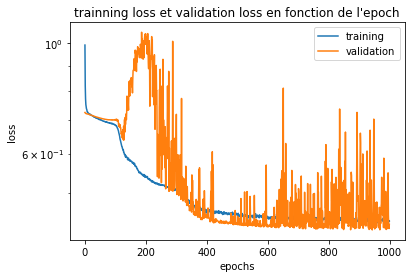

54946/54946 [==============================] - 63s 1ms/step - loss: 0.4574 - accuracy: 0.7601
Evaluation du modèle:  [0.4573691487312317, 0.7600672841072083]


In [98]:
plt.figure()                    
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.title('trainning loss et validation loss en fonction de l\'epoch')
plt.legend()
plt.show()

ev = combined_model.evaluate(primes10000_prop1_dec[:,1:], primes10000_prop1_dec[:,0])
print('Evaluation du modèle: ', ev)

### Histogramme de la probabilitée de nombres premier 

On distingue clairement 3 zones dans cet histogramme, la premier en 0, la seconde entre 0,55~0,75 et enfin la troisieme vers 0,78

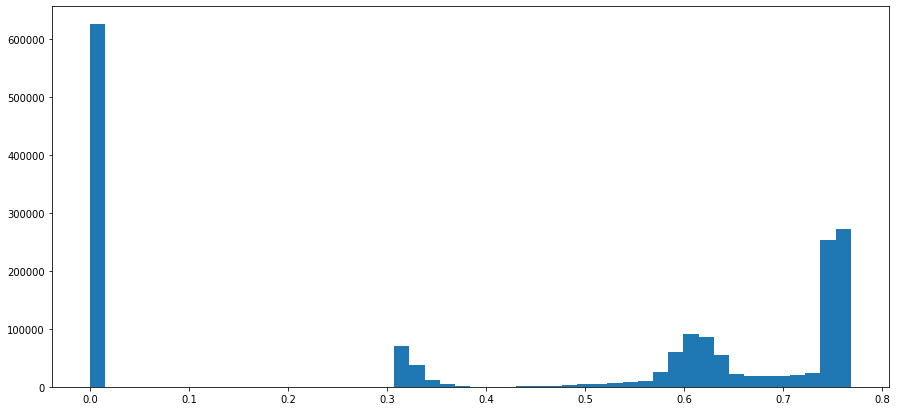

In [113]:
pred = combined_model.predict(primes10000_prop1_dec[:,1:])
fig = plt.subplots(1, 1, figsize=(15, 7))
_ = plt.hist(pred.reshape(len(pred),), bins=50)
plt.show()

In [126]:
print(test[:10])
print(primes10000_prop1_dec[:10])
print(primes1000_prop1_dec.shape[0])

[1094810. 1094811. 1094812. 1094814. 1094820. 1094822. 1094828. 1094831.
 1094833. 1094835.]
[[1. 3. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 7. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 9. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 6. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 5. 2. 0. 0. 0. 0. 1. 0. 0.]
 [0. 7. 2. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 3. 0. 0. 0. 0. 1. 0. 0.]
 [1. 3. 3. 0. 0. 0. 0. 1. 0. 0.]
 [1. 7. 3. 0. 0. 0. 0. 1. 0. 0.]
 [1. 9. 3. 0. 0. 0. 0. 1. 0. 0.]]
19182


In [119]:
np.sum(np.isin(X_pred_test, primes)*1) / X_pred_test.shape[0]

0.3557683071307355

predictions pour P entre 0,3 et 0,4
nombres paires dans les prédictions:  0.8333293277896608
nombres correctement prédits:  0.0
taille de la liste:  41609


predictions pour P entre 0,55 et 0,65
nombres paires dans les prédictions:  0.551168335717692
nombres correctement prédits:  0.20675568272134795
taille de la liste:  62910


predictions pour P entre 0,65 et 0,73
nombres paires dans les prédictions:  0.5042097456702875
nombres correctement prédits:  0.24116971309747123
taille de la liste:  68769


predictions pour P superieur a 0,73
nombres paires dans les prédictions:  0.0
nombres correctement prédits:  0.6076974800678813
taille de la liste:  31231




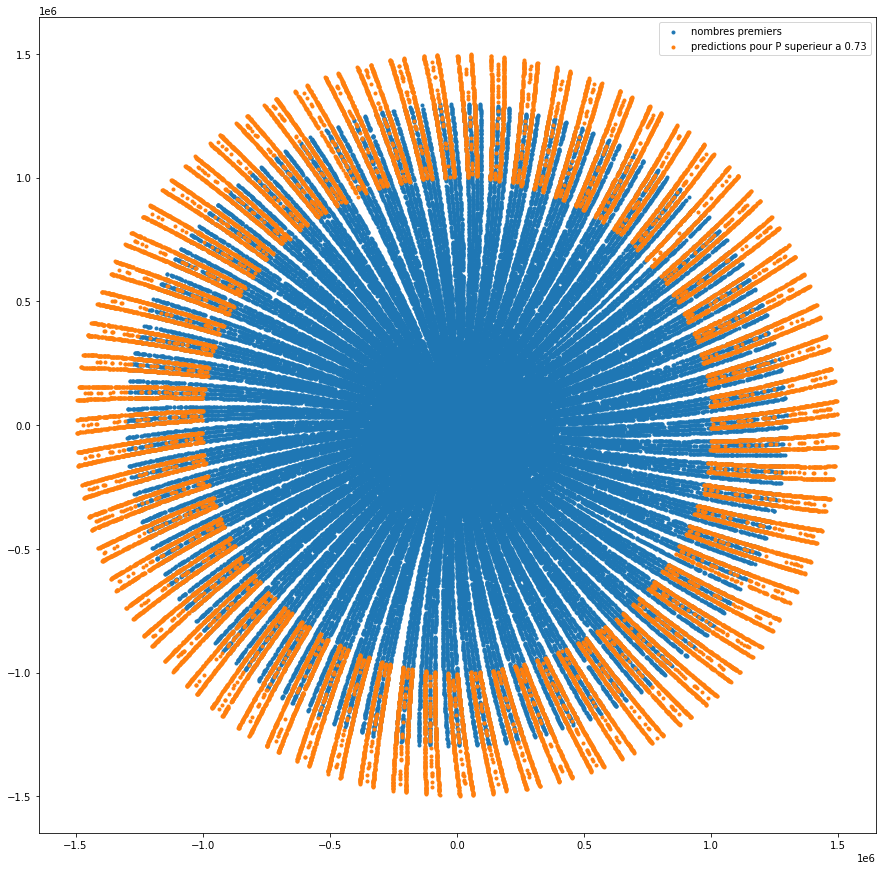

In [134]:
n=100000

pred = combined_model.predict(primes10000_prop1_dec[:n,1:]) # on fait des predictions avec le modele

fig = plt.subplots(1, 1, figsize=(15, 15))
plt.scatter(primes[:n]*np.cos(primes[:n]), primes[:n]*np.sin(primes[:n]), marker='.', label='nombres premiers')

#############################

test = conv_pnums(0, n) # on recupere les index 

X_pred = (pred > 0.3)*1 
X_pred = (pred < 0.4)*1
X_pred = X_pred.reshape(len(X_pred),)
X_pred_test = X_pred*test
X_pred_test = X_pred_test[X_pred_test != 0] # on enleve tous les zeros

pred_score = X_pred_test[X_pred_test%2 != 1].shape[0] / X_pred_test.shape[0]
pred_acc = np.isin(X_pred_test, primes)
print('predictions pour P entre 0,3 et 0,4')
print("nombres paires dans les prédictions: ", pred_score)
print("nombres correctement prédits: ", np.sum(pred_acc*1) / X_pred_test.shape[0])
print('taille de la liste: ', X_pred_test.shape[0])
print('\n')

#plt.scatter(X_pred_test[:n]*np.cos(X_pred_test[:n]), X_pred_test[:n]*np.sin(X_pred_test[:n]), marker='.', label='predictions pour P superieur a 0.76')

X_pred = (pred > 0.55)*1 
X_pred = (pred < 0.65)*1
X_pred = X_pred.reshape(len(X_pred),)
X_pred_test = X_pred*test
X_pred_test = X_pred_test[X_pred_test != 0] # on enleve tous les zeros

pred_score = X_pred_test[X_pred_test%2 != 1].shape[0] / X_pred_test.shape[0]
pred_acc = np.isin(X_pred_test, primes)
print('predictions pour P entre 0,55 et 0,65')
print("nombres paires dans les prédictions: ", pred_score)
print("nombres correctement prédits: ", np.sum(pred_acc*1) / X_pred_test.shape[0])
print('taille de la liste: ', X_pred_test.shape[0])
print('\n')

#plt.scatter(X_pred_test[:n]*np.cos(X_pred_test[:n]), X_pred_test[:n]*np.sin(X_pred_test[:n]), marker='.', label='predictions pour P superieur a 0.76')

X_pred = (pred > 0.65)*1 
X_pred = (pred < 0.73)*1
X_pred = X_pred.reshape(len(X_pred),)
X_pred_test = X_pred*test
X_pred_test = X_pred_test[X_pred_test != 0] # on enleve tous les zeros

pred_score = X_pred_test[X_pred_test%2 != 1].shape[0] / X_pred_test.shape[0]
pred_acc = np.isin(X_pred_test, primes)
print('predictions pour P entre 0,65 et 0,73')
print("nombres paires dans les prédictions: ", pred_score)
print("nombres correctement prédits: ", np.sum(pred_acc*1) / X_pred_test.shape[0])
print('taille de la liste: ', X_pred_test.shape[0])
print('\n')

#plt.scatter(X_pred_test[:n]*np.cos(X_pred_test[:n]), X_pred_test[:n]*np.sin(X_pred_test[:n]), marker='.', label='predictions pour P superieur a 0.76')

X_pred = (pred > 0.73)*1 
X_pred = X_pred.reshape(len(X_pred),)
X_pred_test = X_pred*test
X_pred_test = X_pred_test[X_pred_test != 0] # on enleve tous les zeros

pred_score = X_pred_test[X_pred_test%2 != 1].shape[0] / X_pred_test.shape[0]
pred_acc = np.isin(X_pred_test, primes)
print('predictions pour P superieur a 0,73')
print("nombres paires dans les prédictions: ", pred_score)
print("nombres correctement prédits: ", np.sum(pred_acc*1) / X_pred_test.shape[0])
print('taille de la liste: ', X_pred_test.shape[0])
print('\n')

plt.scatter(X_pred_test[:n]*np.cos(X_pred_test[:n]), X_pred_test[:n]*np.sin(X_pred_test[:n]), marker='.', label='predictions pour P superieur a 0.73')



plt.legend()
plt.show()

## Representations experimentale

Representation polaire de la repartitions des nombres premiers

(explication: https://math.stackexchange.com/questions/885879/meaning-of-rays-in-polar-plot-of-prime-numbers#885894)

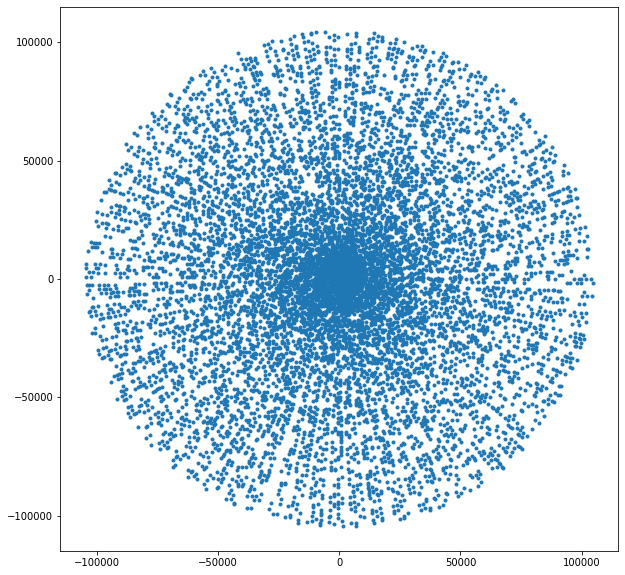

In [18]:
n = 10000
fig = plt.subplots(1, 1, figsize=(10, 10))
plt.scatter(primes[:n]*np.cos(primes[:n]), primes[:n]*np.sin(primes[:n]), marker='.')
plt.show()

# Résultats

Comme on peut le voir sur les graphiques ci-dessus, le modèle sans les multiples est incapable de faire une quelquonce prédiction, tous les nombres ont la même probabilité d'être premier. 

Tandis que pour le dataset avec les multiples nous obtenons déjà des résultats plus interessant. 
On peut voir que certains point correspondent et qu'ils ont donc bien été prédit.

Toutefois il reste encore des erreurs et pour cela il faut pouvoirs essayer d'autres méthodes, on va donc essayer avec un dataset en binaire pour voir quel impact cela va avoir sur les prédictions du modèle. 